In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
import   parameters
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error,mean_squared_error
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

starting of paralle.py
paralle.py/parallel is printing


In [6]:
# top 3
# C+ St Plk
# C+ St NT3
# Pr Plk


# region top
# North Atlantic
# Carolinas
# Midwest East
# Midwest Central
# Texas and South Plains
# Pacific Northwest            

In [2]:
def preprocess_data(df,region,forecast):
    df=df[df['Product Segment'].isin(['Exterior','Interior'])]
    df=df[df['Region Name']!='Export/Interco']
    df=df[df['Region Name']==region]
    df=df[df['forecast_group']==forecast]
    df=df[['Order Create Date','Order Volume (STD)']] # columns you want
    df['Order Create Date']=pd.to_datetime(df['Order Create Date'])
    df=df.sort_values(by='Order Create Date')
    df=df.reset_index(drop=True)
    df['year'] = df['Order Create Date'].dt.year
    df['month'] = df['Order Create Date'].dt.month
    df = df.groupby(['year', 'month'])['Order Volume (STD)'].sum().reset_index()
    df['date']=df['year'].astype('string')+'-'+df['month'].astype('string')+'-01'
    df.set_index('date',inplace=True)
    df=df.drop(['year','month'],axis=1)
    df.index=pd.to_datetime(df.index)
    return df
# check stationary test dickey fuller test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


In [3]:
forecast='C+ St NT3'	
region='Midwest Central'
df=pd.read_parquet('tezcatli_orders_data.parquet')

In [4]:
df=preprocess_data(df,region,forecast)

In [5]:
adf_test(df['Order Volume (STD)'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.392170
p-value                   0.586024
# lags used              11.000000
# observations          112.000000
critical value (1%)      -3.490131
critical value (5%)      -2.887712
critical value (10%)     -2.580730
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [29]:
adf_test(df['Order Volume (STD)'].diff(1).dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.523209e+00
p-value                 3.743211e-11
# lags used             1.000000e+01
# observations          1.120000e+02
critical value (1%)    -3.490131e+00
critical value (5%)    -2.887712e+00
critical value (10%)   -2.580730e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [30]:
# data has seasonality and it is yearly seasonal

auto_arima_result                                      SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  124
Model:             SARIMAX(2, 0, 2)x(0, 0, 2, 12)   Log Likelihood               -1678.269
Date:                            Wed, 06 Sep 2023   AIC                           3372.539
Time:                                    17:55:18   BIC                           3395.101
Sample:                                04-01-2013   HQIC                          3381.704
                                     - 07-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.315e+05   1.24e+05      1.061      0.289   -1.11e+05    3.75e+05
ar.L1         -0.

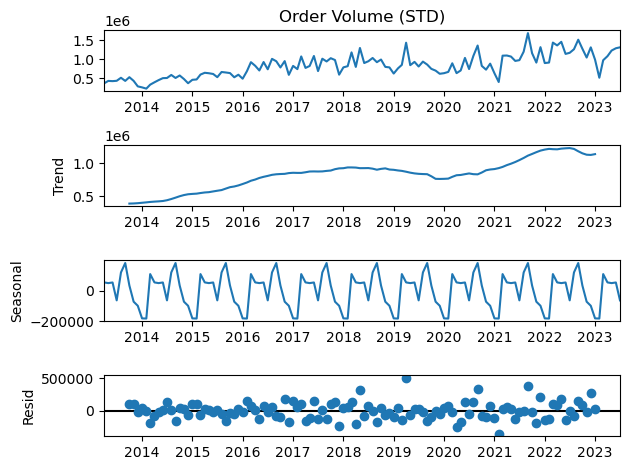

In [6]:
sd=seasonal_decompose(df['Order Volume (STD)'])
sd.plot();
auto_arima_result=auto_arima(df['Order Volume (STD)'],seasonal=True,m=12,start_p=1,d=1,max_p=8,max_d=6,max_q=8,D=4,max_P=6,max_D=4,stationary=True).summary()
print('auto_arima_result',auto_arima_result)

In [7]:
def allinOne_val(df,p,d,q,seasonal_order,trend_offsetint=None):
    # df.plot()
    # sd=seasonal_decompose(df['Order Volume (STD)'])
    # sd.plot();
    # auto_arima_result=auto_arima(df['Order Volume (STD)'],seasonal=True,m=m,start_p=1,d=1,max_p=8,max_d=6,max_q=8,D=4,max_P=6,max_D=4,stationary=True).summary()
    # print('auto_arima_result',auto_arima_result)
    train=df[:'2022-06-01']
    val=df['2022-07-01':'2023-01-01']
    # test=df['2023-02-01':]
    start=len(train)
    end=len(train) + len(val)-1
    model=SARIMAX(train['Order Volume (STD)'],order=(p, d, q),trend_offsetint=1,seasonal_order=seasonal_order)
    results=model.fit()
    predictions_val=results.predict(start,end).rename('SARIMAX  predict')
    val['Order Volume (STD)'].plot(figsize=(12,6),legend=True,title='Validation plot ')
    predictions_val.plot(legend=True)
    plt.show()
    print('mean_absolute_percentage_error of validation',mean_absolute_percentage_error(val['Order Volume (STD)'],predictions_val)*100)
    print('root_mean_square_error of validation',mean_squared_error(val['Order Volume (STD)'],predictions_val)**0.5)

In [33]:
parameters.param

{'Carolinas_C+ St Plk': (3, 0, 3, (0, 0, [1, 2], 12)),
 'North Atlantic_C+ St Plk': (3, 0, 2, (1, 0, [1], 12)),
 'Midwest East_C+ St NT3': (1, 0, 2, (1, 0, [], 12)),
 'Midwest Central_C+ St NT3': (2, 0, 2, (0, 0, 2, 12)),
 'Texas and South Plains_Pr Plk': (4, 0, 0, (0, 0, 0, 0)),
 'Pacific Northwest_Pr Plk': (2, 0, 0, (1, 0, 0, 12)),
 'b': 0}

In [8]:
parameters.param

{'Carolinas_C+ St Plk': (3, 0, 3, (0, 0, [1, 2], 12)),
 'North Atlantic_C+ St Plk': (3, 0, 2, (1, 0, [1], 12)),
 'Midwest East_C+ St NT3': (1, 0, 2, (1, 0, [], 12)),
 'Midwest Central_C+ St NT3': (2, 0, 2, (0, 0, 2, 12)),
 'Texas and South Plains_Pr Plk': (4, 0, 0, (0, 0, 0, 0)),
 'Pacific Northwest_Pr Plk': (2, 0, 0, (1, 0, 0, 12)),
 'b': 0}

In [35]:
parameters.param[' Plk'] 

(2, 0, 0, (1, 0, 0, 12))

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19969D+01    |proj g|=  1.69310D+01

At iterate    5    f=  1.36055D+01    |proj g|=  1.40825D-01

At iterate   10    f=  1.35324D+01    |proj g|=  3.25901D-02

At iterate   15    f=  1.35202D+01    |proj g|=  5.24524D-03

At iterate   20    f=  1.35188D+01    |proj g|=  5.90535D-04

At iterate   25    f=  1.35187D+01    |proj g|=  1.51383D-03

At iterate   30    f=  1.35186D+01    |proj g|=  1.56888D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

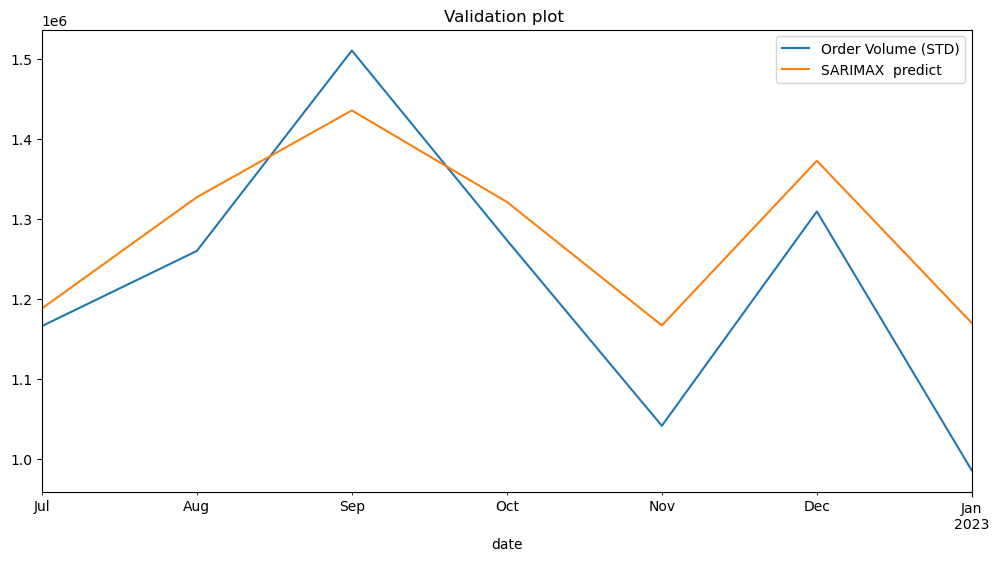

mean_absolute_percentage_error of validation 7.356366805017148
root_mean_square_error of validation 97501.48045138113


In [8]:
p,d,q,seasonal_order= parameters.param['Midwest Central_C+ St NT3'] # CHANGE POINT SARIMAX(2, 0, 0)x(1, 0, 0, 12) 
allinOne_val(df,p,d,q,seasonal_order=seasonal_order) 

In [9]:
def allinOne(df,p,d,q,seasonal_order,trend_offsetint=None):
    # df.plot()
    # sd=seasonal_decompose(df['Order Volume (STD)'])
    # sd.plot();
    # auto_arima_result=auto_arima(df['Order Volume (STD)'],seasonal=True,m=m,start_p=1,d=1,max_p=8,max_d=6,max_q=8,D=4,max_P=6,max_D=4,stationary=True).summary()
    # print('auto_arima_result',auto_arima_result)
    train=df[:'2023-01-01']
    # val=df['2022-07-01':'2023-01-01']
    test=df['2023-02-01':]
    start=len(train)
    end=len(train) + len(test)-1
    model=SARIMAX(train['Order Volume (STD)'],order=(p, d, q),trend_offsetint=1,seasonal_order=seasonal_order)
    results=model.fit()
    predictions_val=results.predict(start,end).rename('SARIMAX  predict')
    test['Order Volume (STD)'].plot(figsize=(12,6),legend=True,title='Actual vs Predicted plot ')
    predictions_val.plot(legend=True)
    plt.show()
    print('mean_absolute_percentage_error of validation',mean_absolute_percentage_error(test['Order Volume (STD)'],predictions_val)*100)
    print('root_mean_square_error of validation',mean_squared_error(test['Order Volume (STD)'],predictions_val)**0.5)

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27836D+01    |proj g|=  1.83641D+01

At iterate    5    f=  1.35994D+01    |proj g|=  1.99483D-01

At iterate   10    f=  1.35163D+01    |proj g|=  2.13161D-02

At iterate   15    f=  1.35010D+01    |proj g|=  8.43756D-03

At iterate   20    f=  1.34989D+01    |proj g|=  1.08368D-03

At iterate   25    f=  1.34987D+01    |proj g|=  2.08573D-03

At iterate   30    f=  1.34986D+01    |proj g|=  5.89884D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

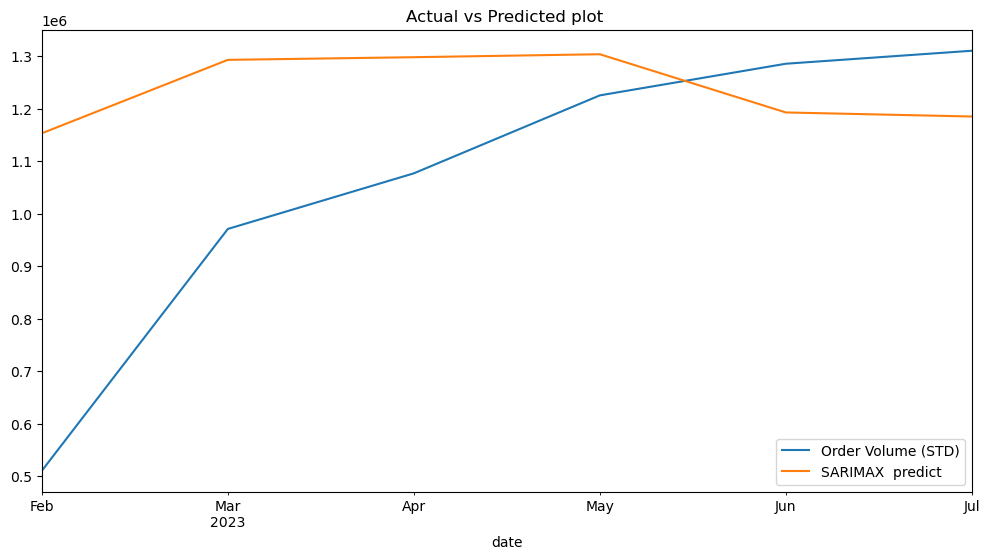

mean_absolute_percentage_error of validation 33.7746694456736
root_mean_square_error of validation 315071.2911797306


In [10]:
allinOne(df,p,d,q,seasonal_order=seasonal_order)

In [13]:
# # test=df['2022-11-01':]
# start=len(train_1)
# end=len(train_1) + 10
# model=SARIMAX(train_1['Order Volume (STD)'],order=(1, 2, 10),seasonal_order=(4,5,3,12))
# results=model.fit()
# predictions=results.predict(start,end).rename('SARIMAX  predict')

In [14]:
# train=df[:'2022-10-01']
# # val=df[:'2022-10-01']
# test=df['2022-11-01':]
# start=len(train)
# end=len(train) + len(test)-1
# model=SARIMAX(train['Order Volume (STD)'],order=(5, 4, 1),seasonal_order=(1,0,0,12))
# model.initialize_approximate_diffuse()
# results=model.fit()
# predictions=results.predict(start,end).rename('SARIMAX  predict')
# test['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
# predictions.plot(legend=True)
# plt.ylabel('Order Volume (STD)')
# plt.title('Comaparison Actual vs Predited')
# plt.show()
# print('mean_absolute_percentage_error_val',mean_absolute_percentage_error(test['Order Volume (STD)'],predictions)*100)

In [98]:
pd.DataFrame(predictions)

,SARIMAX predict
2022-11-01,4.762587e+06
2022-12-01,4.965846e+06
2023-01-01,4.459582e+06
2023-02-01,4.867547e+06
2023-03-01,4.872237e+06
2023-04-01,4.649241e+06
2023-05-01,4.964498e+06
2023-06-01,4.970941e+06
2023-07-01,4.689723e+06


In [99]:
test

,Order Volume (STD)
date,
2022-11-01,3284587.6
2022-12-01,2855132.2
2023-01-01,1713398.2
2023-02-01,1954789.0
2023-03-01,2425312.4
2023-04-01,2660091.0
2023-05-01,3226377.8
2023-06-01,2852139.6
2023-07-01,2112256.0


### Final 

In [49]:
# model2=SARIMAX(train['Order Volume (STD)'],order=(10, 1, 10))
# results2=model2.fit()
# predictions2=results2.predict(start,end).rename('SARIMAX  predict')
# test['Order Volume (STD)'].plot(figsize=(12,6),legend=True,label='Order Volume (STD) Actual')
# predictions2.plot(legend=True)
# # plt.xticks('')
# plt.ylabel('Order Volume (STD)')
# plt.title('Comaparison Actual vs Predited')
# print('mean_absolute_error',mean_absolute_error(test['Order Volume (STD)'],predictions2))
# print("MAPE",mean_absolute_percentage_error(test['Order Volume (STD)'],predictions2))

In [ ]:
# import pandas as pd
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_absolute_error
# import matplotlib.pyplot as plt

# # Load your time series data into a pandas DataFrame
# # Replace this with your actual data loading code
# data = pd.read_csv('your_time_series_data.csv')

# # Choose the split points
# train_end = int(len(data) * 0.7)  # 70% for training
# val_end = int(len(data) * 0.85)   # 15% for validation, remaining for test

# # Split the data
# train = data[:train_end]
# validation = data[train_end:val_end]
# test = data[val_end:]

# # Fit the model on the training data
# model = SARIMAX(train['Order Volume (STD)'], order=(10, 1, 10))
# results = model.fit()

# # Make predictions on the validation set
# predictions_val = results.predict(start=len(train), end=len(train) + len(validation) - 1)

# # Calculate mean absolute error on the validation set
# mae_val = mean_absolute_error(validation['Order Volume (STD)'], predictions_val)
# print('Validation MAE:', mae_val)

# # Make predictions on the test set
# predictions_test = results.predict(start=len(train) + len(validation), end=len(data) - 1)

# # Calculate mean absolute error on the test set
# mae_test = mean_absolute_error(test['Order Volume (STD)'], predictions_test)
# print('Test MAE:', mae_test)

# # Plot the actual data, validation predictions, and test predictions
# plt.figure(figsize=(12, 6))
# data['Order Volume (STD)'].plot(label='Actual')
# predictions_val.plot(label='Validation Predictions')
# predictions_test.plot(label='Test Predictions')
# plt.legend()
# plt.title('SARIMA Model: Actual vs. Predicted')
# plt.xlabel('Time')
# plt.ylabel('Order Volume (STD)')
# plt.show()
